In [1]:
from utils.GenerateGraphMatrices import GenerateGraphMatrices, StrengthAlter
from utils.Simulator import Simulator
from utils.ImmunizationPolicies import Policy
import json, os, math, scipy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline

In [2]:
home_dir = os.environ['GDMPATH']+'/'
data_dir = "datasets/"
results_dir = "results/"
with open(home_dir+"hyper_params.json") as f:
    hyper = json.load(f)

In [ ]:
def plot_beta(G1, G2, alpha):
    beta = [i/100 for i in range(1,100,2)]
    axis = [i for i in range(0, len(beta))]
    EffStren = []
    check=True
    for i in axis:
        S1 = G1.GenSystemMatrix(alpha, beta[i])
        S2 = G1.GenSystemMatrix(alpha, beta[i])
        EffStren.append(abs(StrengthAlter(S1, S2).value(n=1)[0]))
        if (EffStren[i] > 1.0 and check==True):
            print("Minimum Transmisssion Probablity for an Epidemic is {}".format(beta[i]))
            check=False
    plt.plot(beta, EffStren)
    plt.title('Effective Strength plot by varying Transmission Probablity (Under Hp={})'.format(alpha))
    plt.axhline(y=1,linestyle='--',linewidth=3,color='red')
    plt.xlabel("Transmission Probability -->")
    plt.ylabel("Effective Strength Value -->")
    plt.show()
    return None

def plot_alpha(G1, G2, beta):
    alpha = [i/100 for i in range(1,100, 2)]
    axis = [i for i in range(0, len(alpha))]
    print(len(alpha), len(axis))
    EffStren = []
    check=True
    for i in axis:
        S1 = G1.GenSystemMatrix(alpha[i], beta)
        S2 = G1.GenSystemMatrix(alpha[i], beta)
        EffStren.append(abs(StrengthAlter(S1, S2).value(n=1)[0]))
        if (EffStren[i] < 1.0 and check==True):
            print("Maximum Healing Probablity for an Epidemic is {}".format(alpha[i]))
            check=False
    plt.plot(alpha, EffStren)
    plt.title('Effective Strength plot by varying Healing Probablity (Under Tp={})'.format(beta))
    plt.axhline(y=1,linestyle='--',linewidth=3,color='red')
    plt.xlabel("Healing Probability -->")
    plt.ylabel("Effective Strength Value -->")
    plt.show()
    return EffStren

In [ ]:
G1 = GenerateGraphMatrices()
G1.GenGraphObj(EdgeFilePath=home_dir+data_dir+"alternating/alternating1.network")

G2 = GenerateGraphMatrices()
G2.GenGraphObj(EdgeFilePath=home_dir+data_dir+"alternating/alternating2.network")

S11 = G1.GenSystemMatrix(hyper['alpha']['1'], hyper['beta']['1'])
S12 = G2.GenSystemMatrix(hyper['alpha']['1'], hyper['beta']['2'])
EffStren1 = StrengthAlter(S11, S11).value(n=1)

S21 = G2.GenSystemMatrix(hyper['alpha']['2'], hyper['beta']['2'])
S22 = G2.GenSystemMatrix(hyper['alpha']['2'], hyper['beta']['2'])
EffStren2 = StrengthAlter(S12, S22).value(n=1)

# print('Note: Tp => Transmission Probability, Hp => Healing Probability')
# print("\n")
# print('Using Tp1 : {}, Tp2 : {}'.format(hyper['beta']['1'], hyper['beta']['2']))
# print('Effective Strength: {}'.format(abs(EffStren1[0])))
# print("\n")
# print('Using Hp1 : {}, Hp2 : {}'.format(hyper['alpha']['1'], hyper['alpha']['2']))
# print('Effective Strength: {}'.format(abs(EffStren2[0])))

plot_beta(G1, G2, alpha=0.70)
plot_beta(G1, G2, alpha=0.20)
plot_alpha(G1, G2, beta=0.20)
plot_alpha(G1, G2, beta=0.01)

In [ ]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
Results = []
for i in range(0,10):
    Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))
    Results.append(list(list(Simulate.give_stats().values())[0].values()))
arr = np.array(Results)
print(arr.shape)
arr = np.average(arr, axis=0)
plt.plot([i for i in range(1, arr.shape[0]+1)], arr.tolist())
plt.title('Simulation Results for Tp:{}, Hp:{}'.format(hyper['beta']['1'], hyper['alpha']['1']))
plt.xlabel("TimeSteps -->")
plt.ylabel("Fraction of Nodes Infected -->")
plt.show()

In [ ]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
Results = []
for i in range(0,10):
    Simulate.start(100, float(hyper['alpha']['2']), float(hyper['beta']['2']))
    Results.append(list(list(Simulate.give_stats().values())[0].values()))
arr = np.array(Results)
arr = np.average(arr, axis=0)
plt.plot([i for i in range(1, arr.shape[0]+1)], arr.tolist())
plt.title('Simulation Results for Tp:{}, Hp:{}'.format(hyper['beta']['2'], hyper['alpha']['2']))
plt.xlabel("TimeSteps -->")
plt.ylabel("Fraction of Nodes Infected -->")
plt.show()

In [3]:
def custom(G1, G2, alpha, beta):
    Adj1 = nx.to_scipy_sparse_matrix(G1, format='csc')
    Adj2 = nx.to_scipy_sparse_matrix(G2, format='csc')
    Identity = scipy.sparse.identity(G1.number_of_nodes(), format='csc')
    S1 = Identity.multiply(1-float(alpha)) + Adj1.multiply(float(beta))
    S2 = Identity.multiply(1-float(alpha)) + Adj2.multiply(float(beta))
    return StrengthAlter(S1, S2).value()

In [4]:
# Finding Effective Sterength after Immunization:
results_dir = home_dir+"results/sim_results"
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"

Simulate = Simulator(A1, A2, results_dir)
Simulate.initialize()
infected_nodes = Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))

print("..........................................Policy A...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.A(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy B...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.B(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy C...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.C(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy D...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.D(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

Simulation has been completed
..........................................Policy A...........................................................
Before Immunization: 372
After Immunization: 356
[80.47807678]
..........................................Policy B...........................................................
Before Immunization: 372
After Immunization: 330
[1.08098485]
..........................................Policy C...........................................................
Before Immunization: 372
200 271
After Immunization: 334
[1.04681282]
..........................................Policy D...........................................................
Before Immunization: 372
After Immunization: 353
[26.8368125]


In [ ]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
infected_nodes = Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))

Before Immunization: 372
100 271
After Immunization: 350
Before Immunization: 372
150 271
After Immunization: 338
Before Immunization: 372
200 271
After Immunization: 334
Before Immunization: 372
250 271
After Immunization: 327
Before Immunization: 372
300 271
After Immunization: 323
Before Immunization: 372
350 271
After Immunization: 319
Before Immunization: 372
400 271
After Immunization: 314
Before Immunization: 372
450 271
After Immunization: 309
Before Immunization: 372
500 271
After Immunization: 303
Before Immunization: 372
550 271
After Immunization: 302
Before Immunization: 372
600 271
After Immunization: 300
Before Immunization: 372
650 271
After Immunization: 298
Before Immunization: 372
700 271
After Immunization: 294
Before Immunization: 372
750 271
After Immunization: 291
Before Immunization: 372
800 271
After Immunization: 288
Before Immunization: 372
850 271
After Immunization: 282
Before Immunization: 372
900 271
After Immunization: 278
Before Immunization: 372
950 27

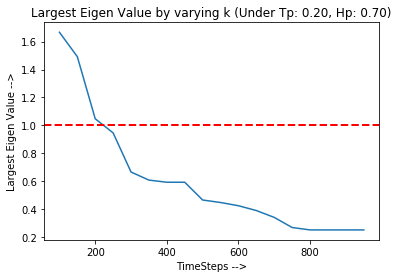

In [22]:
Results = []
axis = []
for k in range(100,1000,50):
    Immunize = Policy(A1, A2, results_dir)
    Immunize.C(k, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
    G1 = Immunize.Graph1
    G2 = Immunize.Graph2
    try:
        Results.append(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1'])))[0])
        axis.append(k)
    except:
        print("Failed for the value k : " + str(k))
plt.plot(axis, Results)
plt.title('Largest Eigen Value Using Policy A by varying k (Under Tp: {}, Hp: {})'.format(hyper['beta']['1'], hyper['alpha']['1']))
plt.xlabel("Number of Vaccines for Immunizationv-->")
plt.ylabel("Largest Eigen Value -->")
plt.axhline(y=1,linestyle='--',linewidth=2,color='red')
plt.show()

In [18]:
print(Results)

[1.6670979967854302, 1.0468128220863768, 0.66500306828331, 0.591712559035712, 0.46438341993307214, 0.4233446620271343, 0.33970562748477173, 0.2500000000000008, 0.2500000000000007, 0.25000000000000033, 0.2500000000000002]


In [19]:
print(axis)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
